# Introduction
## This notebook was uploading by gabseung and created by Co-worker [갑승, 지은, 규수, 혜원, 대현].
## We focused on score(accuracy, F1-score, Au-roc) to improve.
## On a large scale, The analysis was conducted in the order of EDA - Derivative variables Generation - Dimension Reduction - Resampling - ML algorithm - Review about result.

## You can ask Any Question and give Feedback!

# import packages and Setting defaults

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# import smote
# import rus
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
## MEBoost /content/drive/My Drive/fintech/MEBoost/MEBoost.py
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks') 
sys.path.append("/content/drive/My Drive/Colab Notebooks/MB,CB,RF")
sys.path.append("/content/drive/My Drive/Colab Notebooks/차원축소")# MEBoost.py 저장되어있는 경로
import MEBoost
import smote
import rus
## CATBoost
import six
!jupyter nbextension enable --py widgetsnbextension
#from catboost import CatBoostClassifier, Pool, cv

dir = '/content/drive/My Drive/Colab Notebooks/차원축소'


lis = ['UCI_Credit_Card_2','new_X','kernel_linear', 'kernel_rbf', 'LightGBM', 'manifold_LLE', 'manifold_TSNE', 'PCA_0.9', 'PCA_0.95', 'PCA_0.99',
        'RandomForest', 'XGboost']

# read csv

In [0]:
credit = pd.read_csv('/content/drive/My Drive/Colab Notebooks/차원축소/UCI_Credit_Card_2.csv',engine='python')
credit = credit.iloc[:,1:]

In [0]:
credit.describe()

## Data Cleaning

In [0]:
credit.drop(['ID'], inplace=True, axis =1)

credit = credit.rename(columns={'default.payment.next.month': 'default', 
                        'PAY_0': 'PAY_1'})

fill = (credit.EDUCATION == 0) | (credit.EDUCATION == 5) | (credit.EDUCATION == 6)
credit.loc[fill, 'EDUCATION'] = 4

fill2 = (credit.MARRIAGE == 0) | (credit.MARRIAGE == 3)
credit.loc[fill2, 'MARRIAGE'] = 3

# 시각화 


In [0]:
df = credit[credit.default == 0].sample(n=1000)
df2 = credit[credit.default == 1].sample(n=1000)
df3 = pd.concat([df, df2], axis = 0)

standard_scaler = StandardScaler()
df3_std = standard_scaler.fit_transform(df3)

y = df3['default'].values
tsne = TSNE(n_components=2, random_state=0)
x_test_2d = tsne.fit_transform(df3_std)

color_map = {0:'blue', 1:'red'}
plt.figure()
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x = x_test_2d[y==cl,0], 
                y = x_test_2d[y==cl,1], 
                c = color_map[idx], 
                label = cl)
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of sample data')
plt.show()

In [0]:
cols = [ f for f in credit.columns if credit.dtypes[ f ] != "object"]
quant = ["LIMIT_BAL", "AGE"]
qual = cols
output = 'default'
qual.remove("LIMIT_BAL")
qual.remove("AGE")
qual.remove(output)

logged = []
for ii in range(1,7):
    qual.remove("PAY_AMT" + str( ii ))
    credit[ "log_PAY_AMT" + str( ii )] = credit["PAY_AMT" + str( ii )].apply(lambda x: np.log1p(x) if (x>0) else 0 )
    logged.append("log_PAY_AMT" + str( ii ) )

for ii in range(1,7):
    qual.remove("BILL_AMT" + str( ii ))
    credit[ "log_BILL_AMT" + str( ii )] = credit["BILL_AMT" + str( ii )].apply(lambda x: np.log1p(x) if (x>0) else 0 )
    logged.append("log_BILL_AMT" + str( ii ) )
    
features = quant + qual + logged + [output]
corr = credit[features].corr()
plt.figure(figsize = (15, 15))
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
sns.heatmap(corr, square=True, annot=True, fmt=".1f" )  
plt.show()

## Demographical Atrributes
### 1) Sex & Default

In [0]:
sgroup=credit.groupby(['SEX'])[['default']]
sex=sgroup.sum()
sex['count']=sgroup.count()
sex['drate']=sex['default']/sex['count']
sex['arate']=sex['count']/30000
sex['index']=sex.index
print(sex)
s = sns.barplot(x='index', y='drate', data=sex, color='red')
sns.despine(left=True)
s.set_xticklabels(['Male','Female'])
plt.title("Default rate by Sex(%)")
plt.show()

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10,5))

bins1 = 3

ax1.hist(credit.SEX[credit.default == 1], bins = bins1, width=0.3)
ax1.set_title('Default')

ax2.hist(credit.SEX[credit.default == 0], bins = bins1, width=0.3)
ax2.set_title('Paid on time')

plt.xlabel('Sex')
plt.show()

### 2) Education & Default

In [0]:
egroup=credit.groupby(['EDUCATION'])[['default']]
edu=egroup.sum()
edu['count']=egroup.count()
edu['drate']=edu['default']/edu['count']
edu['arate']=edu['count']/30000
edu['index']=edu.index
print(edu)
e = sns.barplot(x='index', y='drate',color='r', data=edu)
sns.despine(left=True)
e.set_xticklabels(['Graduate school','University','High school','Others'])
plt.title("Default rate by Education(%)")
plt.show()

In [0]:
f, (ax3, ax4) = plt.subplots(2, 1, sharex=True, figsize=(10,5))

bins3 = 4

ax3.hist(credit.EDUCATION[credit.default == 1], bins = bins3)
ax3.set_title('Default')

ax4.hist(credit.EDUCATION[credit.default == 0], bins = bins3)
ax4.set_title('Paid on time')
ax4.set_xticks([1, 2, 3, 4])

plt.xlabel('Education')
plt.ylabel('Number of Observations')
plt.show()

### 3) Marital Status & Default

In [0]:
mgroup=credit.groupby(['MARRIAGE'])[['default']]
mar=mgroup.sum()
mar['count']=mgroup.count()
mar['drate']=mar['default']/mar['count']
mar['arate']=mar['count']/30000
mar['index']=mar.index
print(mar)

m = sns.barplot(x='index', y='drate',color='r', data=mar)
sns.despine(left=True)
m.set_xticklabels(['Married','Single','Others'])
plt.title("Default rate by Marital Status(%)")
plt.show()

In [0]:
f, (ax5, ax6) = plt.subplots(2, 1, sharex=True, figsize=(10,5))

bins5 = 3

ax5.hist(credit.MARRIAGE[credit.default == 1], bins = bins5)
ax5.set_title('Default')

ax6.hist(credit.MARRIAGE[credit.default == 0], bins = bins5)
ax6.set_title('Paid on time')
ax6.set_xticks([1, 2, 3])

plt.xlabel('Marital Status')
plt.ylabel('Number of Observations')
plt.show()

### 4) Age & Default

In [0]:
credit["AGE_CAT"] = pd.cut(credit["AGE"],
                  bins=[20,30,40,50,60,80],
                  labels=['20','30','40','50','60'])

agroup=credit.groupby(['AGE_CAT'])[['default']]
age=agroup.sum()
age['count']=agroup.count()
age['drate']=age['default']/age['count']
age['arate']=age['count']/30000
age['index']=age.index
print(age)

a = sns.barplot(x='index', y='drate',color='r', data=age)
sns.despine(left=True)
a.set_xticklabels(['20s','30s','40s','50s','over 60s'])
plt.title("Default rate by Age box(%)")
plt.show()

In [0]:
f, (ax7, ax8) = plt.subplots(2, 1, sharex=True, figsize=(10,5))

bins7 = 6

ax7.hist(credit.AGE[credit.default == 1], bins = bins7)
ax7.set_title('Default')

ax8.hist(credit.AGE[credit.default == 0], bins = bins7)
ax8.set_title('Paid on time')

plt.xlabel('Age')
plt.ylabel('Number of Observations')
plt.show()

In [0]:
df=credit[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
data={'Month':['4','5','6','7','8','9'],
      'Default rate':[(df[(df['PAY_6'].astype('float')> 0)]['PAY_6'].count())/300,
                      (df[(df['PAY_5'].astype('float')> 0)]['PAY_5'].count())/300,
                      (df[(df['PAY_4'].astype('float')> 0)]['PAY_4'].count())/300,
                      (df[(df['PAY_3'].astype('float')> 0)]['PAY_3'].count())/300,
                      (df[(df['PAY_2'].astype('float')> 0)]['PAY_2'].count())/300,
                      (df[(df['PAY_1'].astype('float')> 0)]['PAY_1'].count())/300]
      }
dfdp=pd.DataFrame(data)
print(dfdp)

In [0]:
dr = credit.default.sum() / len(credit.default)
print(dr)

In [0]:
dfdp.loc[6]={'Month':'10','Default rate':22.12}
print(dfdp)

In [0]:
g = sns.catplot(x="Month",y='Default rate',kind="bar",aspect=1.2,data=dfdp, 
                order=['4','5','6','7','8','9','10'], color='r')
plt.title('Default rate (%)',size = 16)
plt.show()

In [0]:
groups = credit.groupby('default')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.PAY_1, 
            group.PAY_2, 
            marker='o', 
            linestyle='',
            alpha=0.1,
            label=name)
ax.legend(fontsize=12, loc='upper right') 
plt.title('PAY_1 & PAY_2', fontsize=20)
plt.xlabel('PAY_1', fontsize=14)
plt.ylabel('PAY_2', fontsize=14)
plt.show()

## PAY_CNT, PAY_SUM  ==> 파생변수 생성

In [0]:
pay_df = credit.iloc[:, 5:11]

PAY_CNT = (pay_df > 0).sum(axis = 1)
PAY_SUM = (pay_df*(pay_df > 0)).sum(axis = 1)

credit["PAY_CNT"] = PAY_CNT
credit["PAY_SUM"] = PAY_SUM

PAY_SUM_CAT = pd.DataFrame(pd.cut(credit["PAY_SUM"],
                  bins=[-np.inf, 1, 10, np.inf],
                  labels=list(range(3))))
PAY_SUM_CAT["default"] = credit["default"]

def plot_prop(x, data):
    prop_df = (data["default"]
               .groupby(data[x])
               .value_counts(normalize=True)
               .rename("prop")
               .reset_index())
    sns.barplot(x=x, y="prop", hue="default", data=prop_df)
    
plt.figure(figsize = (5, 5))
plot_prop("PAY_CNT", credit)


In [0]:
plt.figure(figsize = (5, 5))
plot_prop("PAY_SUM", PAY_SUM_CAT)

In [0]:
sns.jointplot("AGE", "PAY_CNT", credit, kind = 'resid')

In [0]:
sns.jointplot("AGE", "PAY_SUM", credit, kind = 'resid')

## USE_AMT, USE_RATE

In [0]:
bal1 = credit.loc[credit['default'] == 1]["LIMIT_BAL"]
bal0 = credit.loc[credit['default'] == 0]["LIMIT_BAL"]

plt.figure(figsize = (12,4))
plt.title('Credit limit & Default rate')
sns.distplot(bal1,kde=True,bins=200, color="r")
sns.distplot(bal0,kde=True,bins=200, color="b")
plt.show()

In [0]:
for i in range(1, 6):
    new = "USE_AMT"+str(i)
    credit[new] = credit["BILL_AMT"+str(i)] - (credit["BILL_AMT"+str(i+1)] - credit["PAY_AMT"+str(i)] )

for i in range(1, 6):
    new = "USE_RATE"+str(i)
    credit[new] = credit["USE_AMT"+str(i)] / credit["LIMIT_BAL"]

In [0]:
USE_AMT_df = credit.loc[:, "USE_AMT1":"USE_AMT5"]
USE_AMT_df['default'] = credit[['default']]

USE_RATE_df = credit.loc[:, "USE_RATE1":"USE_RATE5"]
USE_RATE_df['default'] = credit[['default']]

## Limit Balance

### Age & Limit Balance

In [0]:
groups = credit.groupby('default')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.AGE, 
            group.LIMIT_BAL, 
            marker='o',
            linestyle='',
            alpha=0.1,
            label=name,
           )
ax.legend(fontsize=12, loc='upper right') 
plt.title('Age & Credit limit', fontsize=20)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Credit limit', fontsize=14)
plt.show()

In [0]:
groups = credit.groupby('default')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.AGE, 
            group.EDUCATION, 
            marker='o',
            linestyle='',
            alpha=0.1,
            label=name)
ax.legend(fontsize=12, loc='upper right')
plt.title('Age & Education', fontsize=20)
plt.xlabel('AGE', fontsize=14)
plt.ylabel('EDUCATION', fontsize=14)
plt.show()

# 차원축소


In [0]:
# create the target variable
df = pd.read_csv('C:/Users/rkqtm/New_data/UCI_Credit_Card_2.csv')
df = df.rename(columns={'default.payment.next.month': 'def_pay', 
                        'PAY_0': 'PAY_1'})

fill = (df.EDUCATION == 0) | (df.EDUCATION == 5) | (df.EDUCATION == 6)
df.loc[fill, 'EDUCATION'] = 4

fill2 = (df.MARRIAGE == 0) | (df.MARRIAGE == 3)
df.loc[fill2, 'MARRIAGE'] = 3

y = df['def_pay'].copy()
features = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6','USE_AMT1','USE_AMT2','USE_AMT3',
           'USE_AMT4','USE_AMT5','USE_RATE1','USE_RATE2','USE_RATE3','USE_RATE4','USE_RATE5',
           'PAY_CNT','PAY_SUM']
X = df[features].copy()
X.columns

In [0]:
# SEX, EDUCATION, MARRIAGE, PAY_1, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6 를 범주형변수로 변환
X[['SEX','EDUCATION','MARRIAGE','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']]=X[['SEX','EDUCATION','MARRIAGE','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].astype('category')
X_dummy=pd.get_dummies(X)


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale,robust_scale,minmax_scale

import matplotlib
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import metrics
import warnings

matplotlib.rc('font',family="NanumBarunGothic")

In [0]:
from sklearn.decomposition import PCA
# 90%
pca = PCA(0.90)
X_reduced_pca = pca.fit_transform(X)
# cumsum = np.cumsum(pca.explained_variance_ratio_)
# d = np.argmax(cumsum >= 0.95) + 1

In [0]:
df.columns

In [0]:
a={'PCA_1':X_reduced_pca[:,0],'PCA_2':X_reduced_pca[:,1],'PCA_3':X_reduced_pca[:,2],'PCA_4':X_reduced_pca[:,3],'default':df['def_pay']}
from pandas import DataFrame
data=DataFrame(a)


In [0]:
data.to_csv(dir+'PCA_0.9.csv',header=True)

In [0]:
# 95%
pca = PCA(0.95)
X_reduced_pca = pca.fit_transform(X)
# cumsum = np.cumsum(pca.explained_variance_ratio_)
# d = np.argmax(cumsum >= 0.95) + 1

a={'PCA_1':X_reduced_pca[:,0],'PCA_2':X_reduced_pca[:,1],'PCA_3':X_reduced_pca[:,2],'PCA_4':X_reduced_pca[:,3],
   'PCA_5':X_reduced_pca[:,4],'PCA_6':X_reduced_pca[:,5],'default':df['def_pay']}
from pandas import DataFrame
data=DataFrame(a)

data.to_csv(dir+'PCA_0.95.csv',header=True)

In [0]:
# 99%
pca = PCA(0.99)
X_reduced_pca = pca.fit_transform(X)
# cumsum = np.cumsum(pca.explained_variance_ratio_)
# d = np.argmax(cumsum >= 0.95) + 1

a={'PCA_1':X_reduced_pca[:,0],'PCA_2':X_reduced_pca[:,1],'PCA_3':X_reduced_pca[:,2],'PCA_4':X_reduced_pca[:,3],
   'PCA_5':X_reduced_pca[:,4],'PCA_6':X_reduced_pca[:,5],'PCA_7':X_reduced_pca[:,6],
   'PCA_8':X_reduced_pca[:,7],'PCA_9':X_reduced_pca[:,8],'PCA_10':X_reduced_pca[:,9],
   'PCA_11':X_reduced_pca[:,10],'default':df['def_pay']}
from pandas import DataFrame
data=DataFrame(a)

data.to_csv(dir+'PCA_0.99.csv',header=True)

In [0]:
# grid search RBF, Sigmoid
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import KernelPCA

# clf = Pipeline([
#         ("kpca", KernelPCA(n_components=3)),
#         ("log_reg", LogisticRegression(solver="lbfgs"))
#     ])

# param_grid = [{
#         "kpca__gamma": np.linspace(0.03, 0.05, 10),
#         "kpca__kernel": ["rbf", "sigmoid"]
#     }]

# grid_search = GridSearchCV(clf, param_grid, cv=5)
# grid_search.fit(X_dummy, y)

In [0]:
grid_searchlin_pca = KernelPCA(n_components = 4, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 4, kernel="rbf", fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 4, kernel="sigmoid" , fit_inverse_transform=False)

X_reduced_linear=grid_searchlin_pca.fit_transform(X_dummy)

a={'linear_1':X_reduced_linear[:,0],'linear_2':X_reduced_linear[:,1],'linear_3':X_reduced_linear[:,2],'linear_4':X_reduced_linear[:,3],
   'default':df['def_pay']}

data=DataFrame(a)

data.to_csv(dir+'kernel_rbf.csv',header=True)

In [0]:
X_reduced_sig=sig_pca.fit_transform(X_dummy)

a={'sig_1':X_reduced_sig[:,0],'sig_2':X_reduced_sig[:,1],'sig_3':X_reduced_sig[:,2],'sig_4':X_reduced_sig[:,3],
   'default':df['def_pay']}
from pandas import DataFrame
data=DataFrame(a)
data.to_csv(dir+'kernel_sigmoid.csv',header=True)

In [0]:
# LLE

from sklearn.manifold import LocallyLinearEmbedding
# n_neighbors 는 가장 가까운 샘플의 갯수
lle = LocallyLinearEmbedding(n_components=4, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X_dummy)

a={'LLE_1':X_reduced[:,0],'LLE_2':X_reduced[:,1],'LLE_3':X_reduced[:,2],'LLE_4':X_reduced[:,3],
   'default':df['def_pay']}
from pandas import DataFrame
data=DataFrame(a)
data.to_csv(dir+'LLE.csv',header=True)

# MDS

from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X_dummy)
data.to_csv(dir+'lsomap.csv',header=True)

In [0]:
# TSNE

from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=42)
X_reduced_tsne = tsne.fit_transform(X_dummy)

a={'TSNE_1':X_reduced_tsne[:,0],'TSNE_2':X_reduced_tsne[:,1],'TSNE_3':X_reduced_tsne[:,2],
  'default':df['def_pay']}
from pandas import DataFrame
data=DataFrame(a)

data.to_csv(dir+'TSNE.csv',header=True)

In [0]:
## total 데이터로  분류 그래디언트 부스팅 임포트
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

##랜덤포레스트
from sklearn.ensemble import RandomForestClassifier
## 데이터 분할 함수
from sklearn.model_selection import train_test_split
## 그리드서치
from sklearn.model_selection import GridSearchCV

from sklearn import tree

## 분류 그래디언트 부스팅
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.tools.eval_measures import rmse

import xgboost as xgb
xgb_clf = xgb.XGBClassifier(max_depth=5, n_estimators=100,
    learning_rate=0.2, random_state=42)
xgb_clf.fit(X_dummy, y)

## 변수중요도
feature_importance=pd.DataFrame()
feature_importance["feature"]=X_dummy.columns
feature_importance["importance"]=xgb_clf.feature_importances_

feature_importance.sort_values(by="importance",ascending=False)

a={'PAY_SUM':X_dummy['PAY_SUM'],'PAY_1_2':X_dummy['PAY_1_2'],'PAY_1_3':X_dummy['PAY_1_3'],'PAY_2_2':X_dummy['PAY_2_2'],
   'PAY_2_3':X_dummy['PAY_2_3'],'default':df['def_pay']}

from pandas import DataFrame
data=DataFrame(a)
data.to_csv(dir+'XGboost.csv',header=True)

In [0]:
import lightgbm
from lightgbm import LGBMClassifier

lgb_clf=LGBMClassifier(max_depth=5, n_estimators=100,
    learning_rate=0.2, random_state=42)
# female_gsearch=GridSearchCV(lgb,parameters,n_jobs=-1)
lgb_clf.fit(X_dummy,y)

## 변수중요도
feature_importance=pd.DataFrame()
feature_importance["feature"]=X_dummy.columns
feature_importance["importance"]=lgb_clf.feature_importances_

feature_importance.sort_values(by="importance",ascending=False)

a={'AGE':X_dummy['AGE'],'LIMIT_BAL':X_dummy['LIMIT_BAL'],'PAY_AMT6':X_dummy['PAY_AMT6'],'BILL_AMT1':X_dummy['BILL_AMT1'],
   'USE_RATE3':X_dummy['USE_RATE3'],'default':df['def_pay']}

from pandas import DataFrame
data=DataFrame(a)
data.to_csv(dir+'LightGBM.csv',header=True)

from sklearn.ensemble import RandomForestClassifier

In [0]:
rf_clf=RandomForestClassifier(max_depth=5, n_estimators=100, random_state=42)
rf_clf.fit(X_dummy,y)

## 변수중요도
feature_importance=pd.DataFrame()
feature_importance["feature"]=X_dummy.columns
feature_importance["importance"]=rf_clf.feature_importances_
feature_importance.sort_values(by="importance",ascending=False)

a={'PAY_SUM':X_dummy['PAY_SUM'],'PAY_1_2':X_dummy['PAY_1_2'],'PAY_CNT_0':X_dummy['PAY_CNT_0'],'PAY_2_2':X_dummy['PAY_2_2'],
   'PAY_3_2':X_dummy['PAY_3_2'],'default':df['def_pay']}

from pandas import DataFrame
data=DataFrame(a)
data.to_csv(dir+'RandomForest.csv',header=True)

# 모델링

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import smote
import rus
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

## MEBoost
# import sys
# sys.path.append("C:/Users/rkqtm/MB,CB,RF") # MEBoost.py 저장되어있는 경로
# import MEBoost

## CATBoost
# import six
# !jupyter nbextension enable --py widgetsnbextension
# from catboost import CatBoostClassifier, Pool, cv


In [0]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score

In [0]:
lists = lis.copy()
for i in range(len(lists)):
  a=dir+'/'+lists[i]
  a=a+'.csv'
  lists[i]=pd.read_csv(a)
  # lists[i]=pd.read_csv(dir+lists[i]+'.csv')

In [0]:
# 차원 축소한 데이터프레임 data_name에 저장
data_name = lis.copy()
k=0
for i in lists:
    data_name[k]=pd.DataFrame(i).iloc[:,1:]
    k+=1

In [0]:
# 차원축소 csv파일 이름으로 dictionary data_dic 생성
data_dic = {}
for key, data in enumerate(lis):
    data_dic[data] = data_name[key]

In [0]:
# 데이터 y,X로 나눔
X_dic = {}
y_dic = {}
scX=MinMaxScaler()


for key, data in enumerate(lis):
    y_dic[data] = data_dic[data].iloc[:,-1]
    X_dic[data] = data_dic[data].iloc[:,:-1] 
    X_dic[data]=scX.fit_transform(X_dic[data])
    
X_train = {}
X_test = {}
y_train = {}
y_test = {}
# train, test 8:2로 나눔
for i in lis:
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X_dic[i], y_dic[i], test_size=0.2, random_state =2)



In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from lightgbm import LGBMClassifier


Dt = DecisionTreeClassifier(max_depth=7, random_state = 0)
rf = RandomForestClassifier(n_estimators=100)
Logit = LogisticRegression()
GNB = GaussianNB()
KNN = KNeighborsClassifier(n_neighbors=5)
SVC = SVC(kernel="rbf", gamma = 'auto', C=100) #가우시안 rbf 커널
XGB = xgb.XGBClassifier(n_estimators=100, random_state=42)
lgbm = LGBMClassifier()

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import classification_report

## 모델, 스코어, 모델명 받아서 스코어 리턴해주는 함수
def evaluate_classifier(clf, df_scores, clf_name=None):
    acc_list = []
    bal_acc_list = []
    f1_list=[]
    auc_list = []
    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 5
    
    for i in lis:
        for train_index, test_index in kfold.split(X_train[i]):
            X_cvtrain, X_cvtest = pd.DataFrame(X_train[i]).iloc[train_index], pd.DataFrame(X_train[i]).iloc[test_index]
            y_cvtrain, y_cvtest = y_train[i].iloc[train_index], y_train[i].iloc[test_index]
#         X_train, X_test = X_train.values, X_test.values
            acc = clf.fit(X_cvtrain, y_cvtrain).score(X_cvtest, y_cvtest)
            y_pred = clf.predict(X_cvtest)
            bal_acc = balanced_accuracy_score(y_cvtest, y_pred)
            f1=f1_score(y_cvtest,y_pred)
            auc = roc_auc_score(y_cvtest, y_pred)

            acc_list.append(acc)
            bal_acc_list.append(bal_acc)
            f1_list.append(f1)
            auc_list.append(auc)

        cv_acc = np.mean(acc_list)
        cv_bal_acc = np.mean(bal_acc_list)
        cv_f1=np.mean(f1_list)
        cv_auc = np.mean(auc_list)

        clf_score = pd.DataFrame(
            {i+clf_name: [cv_acc, cv_bal_acc,cv_f1, cv_auc]},
            index=['Accuracy', 'Balanced accuracy','F1score', "auROC"]
        )
        df_scores = pd.concat([df_scores, clf_score], axis=1).round(decimals=3)
    return df_scores


In [0]:
# lists_model = [Logit, Dt, rf, GNB, KNN,SVC,XGB,lgbm]
# model_names = [' _LR',' _Dt',' _Rf',' _GNB',' _KNN',' _SVC',' _XGB',' _lgbm']
lists_model = [XGB,lgbm]
model_names = ['_XGB','_lgbm']

# 모델마다 스코어 넣어줌
def see_score(model_list, model_name):

  df_scores = pd.DataFrame()
    
  for index, key in enumerate(model_list):
      df_scores = evaluate_classifier(key, df_scores, model_name[index])
  return df_scores

df_scores = see_score(lists_model, model_names)
df_scores.to_csv('df_scores.csv')

In [0]:
def adaboost(X_train, X_test, y_train):
  model = AdaBoostClassifier(n_estimators=100, random_state=42)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test) 
  return y_pred
# AdaBoost

df_majority = {}
df_minority = {}
X_train_sm = {}
y_train_sm = {}
y_baseline = {}
y_smote = {}
X_maj_rus = {}
X_rus= {}
y_rus = {}
X_train_rus = {}
y_train_rus = {}

for data in lis:
  df_majority[data] = data_dic[data][data_dic[data]['default']==0]
  
  df_minority[data] = data_dic[data][data_dic[data]['default']==1]

  y_baseline[data] = adaboost(X_train[data], X_test[data], y_train[data])

# SMOTE
  sm = SMOTE(random_state=42)
  # x_train, y_train 데이터를 가지고 스모뜨(up sampling), y_smote[data]는 스모트데이터 adaboost한거
  X_train_sm[data], y_train_sm[data] = sm.fit_sample(X_train[data], y_train[data])
  y_smote[data] = adaboost(X_train_sm[data], X_test[data], y_train_sm[data])

    # RUS
  X_maj_rus[data] = resample(df_majority[data], replace=False, n_samples=len(df_minority[data]),random_state=44)

  X_rus[data] = pd.concat([X_maj_rus[data], df_minority[data]])
  X_train_rus[data] = X_rus[data].drop(['default'], axis=1)
  y_train_rus[data] = X_rus[data].default
  y_rus[data] = adaboost(X_train_rus[data], X_test[data], y_train_rus[data])

  # target_names = ['Not Default', 'Default']
  # for algorithm in [smote.SMOTEBoost(n_estimators=100, n_samples=300),
  #                       rus.RUSBoost(n_estimators=100, n_samples=300)]:
  #   algorithm.fit(X_train[data], y_train[data])
    # y_pred = algorithm.predict(X_test[data])
    # print()
    # print(str(algorithm))
    # print()
    # print(classification_report(y_test[data], y_pred, 
    #                             target_names=target_names))

In [0]:
def evaluate_classifier_rus(clf, df_scores_rus, clf_name=None):
    acc_list = []
    bal_acc_list = []
    f1_list=[]
    auc_list = []

    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 5
    
    for i in lis:
        for train_index, test_index in kfold.split(X_rus[i]):
            X_rustrain, X_rustest = pd.DataFrame(X_train_rus[i]).iloc[train_index], pd.DataFrame(X_train_rus[i]).iloc[test_index]
            y_rustrain, y_rustest = y_train_rus[i].iloc[train_index], y_train_rus[i].iloc[test_index]

            acc = clf.fit(X_rustrain, y_rustrain).score(X_rustest, y_rustest)
            y_pred = clf.predict(X_rustest)
            bal_acc = balanced_accuracy_score(y_rustest, y_pred)
            f1=f1_score(y_rustest,y_pred)
            auc = roc_auc_score(y_rustest, y_pred)

            acc_list.append(acc)
            bal_acc_list.append(bal_acc)
            f1_list.append(f1)
            auc_list.append(auc)

        rus_acc = np.mean(acc_list)
        rus_bal_acc = np.mean(bal_acc_list)
        rus_f1=np.mean(f1_list)
        rus_auc = np.mean(auc_list)

        clf_score = pd.DataFrame(
            {i+clf_name: [rus_acc, rus_bal_acc, rus_f1, rus_auc]},
            index=['Accuracy_rus', 'Balanced accuracy_rus','F1score_rus', "auROC_rus"]
        )
        
        #df_scores_rus =[df_scores_rus, clf_score]

        df_scores_rus = pd.concat([df_scores_rus, clf_score], axis=1).round(decimals=3)
    return df_scores_rus


In [0]:
# lists_model = [Logit, Dt, rf, GNB, KNN,SVC,XGB,lgbm]
# model_names = [' _LR',' _Dt',' _Rf',' _GNB',' _KNN',' _SVC',' _XGB',' _lgbm']
#lists_model = [ GNB]
#model_names = [' _GNB']

def see_score_rus(model_list, model_name):

    df_scores_rus=pd.DataFrame()

    for index, key in enumerate(model_list):
        df_scores_rus = evaluate_classifier_rus(key, df_scores_rus,model_name[index])
    return df_scores_rus

df_scores_rus = see_score_rus(lists_model, model_names)
df_scores_rus.to_csv('df_scores_rus.csv')

In [0]:
def evaluate_classifier_smote(clf, df_scores, clf_name=None):
    acc_list = []
    bal_acc_list = []
    f1_list=[]
    auc_list=[]

    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 5
    
    for i in lis:
        for train_index, test_index in kfold.split(X_train_sm[i]):
            X_smtrain, X_smtest = pd.DataFrame(X_train_sm[i]).iloc[train_index], pd.DataFrame(X_train_sm[i]).iloc[test_index]
            y_smtrain, y_smtest = y_train_sm[i][train_index], y_train_sm[i][test_index]

            acc = clf.fit(X_smtrain, y_smtrain).score(X_smtest, y_smtest)
            y_pred = clf.predict(X_smtest)
            bal_acc = balanced_accuracy_score(y_smtest, y_pred)
            f1=f1_score(y_smtest,y_pred)
            auc = roc_auc_score(y_smtest, y_pred)

            acc_list.append(acc)
            bal_acc_list.append(bal_acc)
            f1_list.append(f1)
            auc_list.append(auc)

        sm_acc = np.mean(acc_list)
        sm_bal_acc = np.mean(bal_acc_list)
        sm_f1=np.mean(f1_list)
        sm_auc = np.mean(auc_list)

        clf_score = pd.DataFrame(
            {i+clf_name: [sm_acc, sm_bal_acc, sm_f1, sm_auc]},
            index=['Accuracy', 'Balanced accuracy','F1score', "auROC"]
        )
        df_scores = pd.concat([df_scores, clf_score], axis=1).round(decimals=3)
    return df_scores


In [0]:
# lists_model = [Logit, Dt, rf, GNB, KNN,SVC,XGB,lgbm]
# model_names = [' _LR',' _Dt',' _Rf',' _GNB',' _KNN',' _SVC',' _XGB',' _lgbm']

#lists_model = [GNB]
#model_names = [' _GNB']


def see_score_smote(model_list, model_name):

  df_scores_smote = pd.DataFrame()

  for index, key in enumerate(model_list):
      df_scores_smote = evaluate_classifier_smote(key, df_scores_smote, model_name[index])
  return df_scores_smote

df_scores_smote = see_score_smote(lists_model, model_names)
df_scores_smote.to_csv('df_scores_smote.csv')

In [0]:
import MEBoost

## CATBoost
import six
!jupyter nbextension enable --py widgetsnbextension
#from catboost import CatBoostClassifier, Pool, cv


In [0]:
def MeBoost(X_train, y_train, X_test, n_estimators = 100, depth = None, split = 2):
  
  # n_extimators : iteration
  # depth : max_depth of tree
  # split : min_sample_split of tree
  # neighbours : 3

    if (isinstance(X_train, np.ndarray) == False):
        X_train = X_train.values
    if (isinstance(y_train, np.ndarray) == False):
        y_train = y_train.values
    meb = MEBoost.AdaBoost(n_estimators, depth, split, neighbours=3)
    meb.fit(X_train, y_train)
    y_pred = meb.predict(X_test)

    return(y_pred[0])

In [0]:
All_y_pred_M = {}
for i in lis:
    All_y_pred_M[i] = MeBoost(X_train[i], y_train[i], X_test[i])

In [ ]:
for i in lis:
    print(classification_report(y_test[i], All_y_pred_M[i]))

# **Summary**

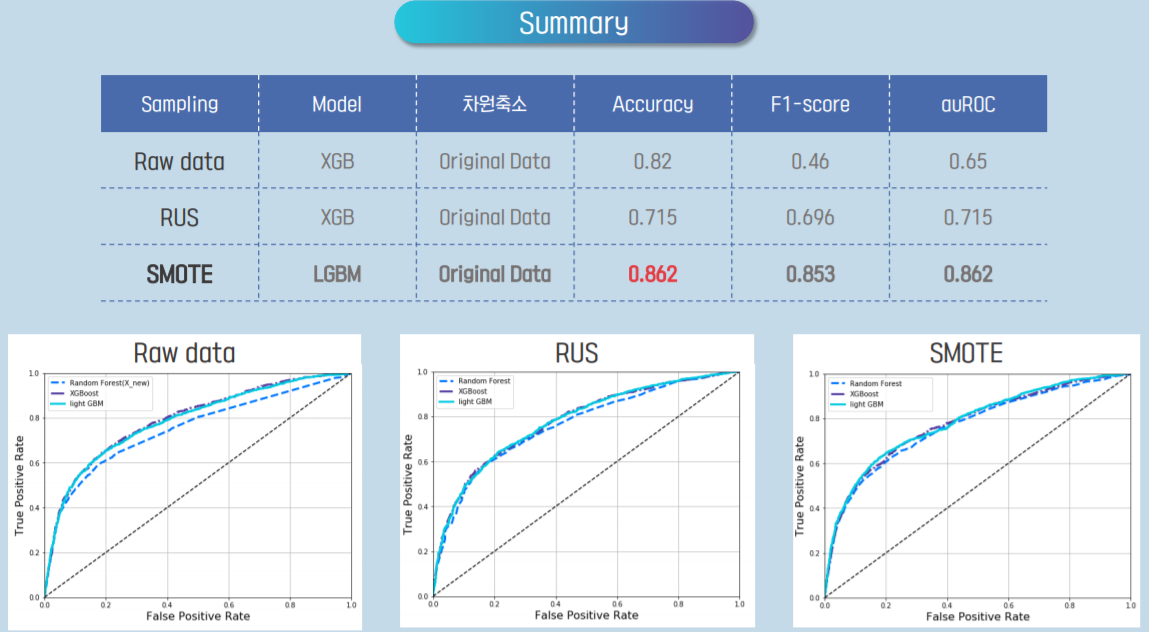

## example of result

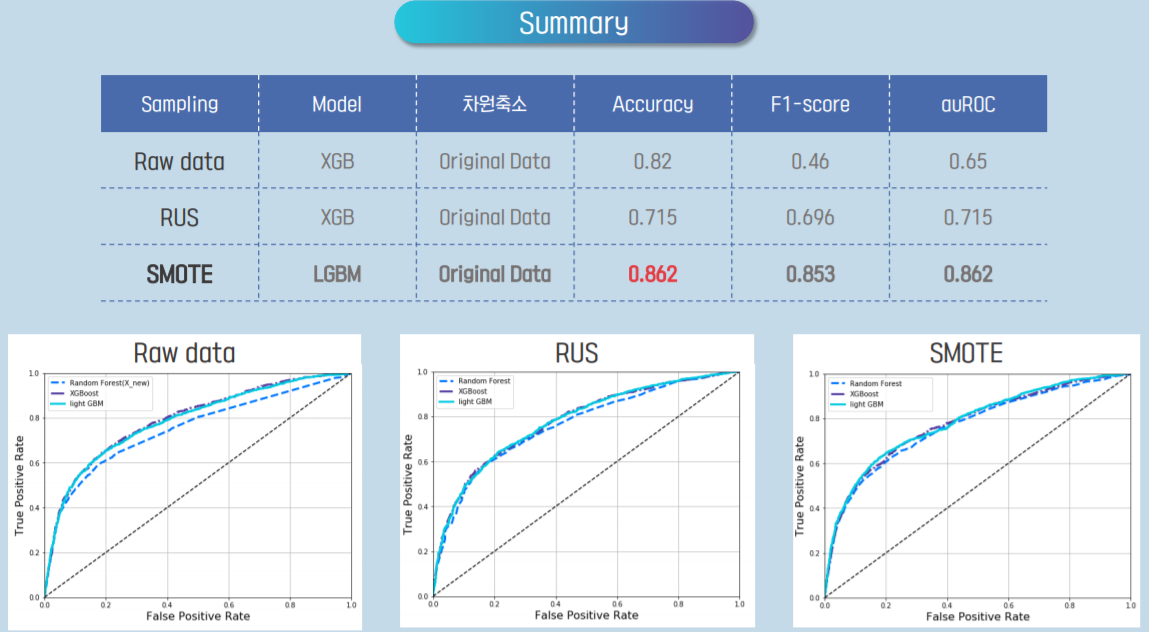

## Total summary

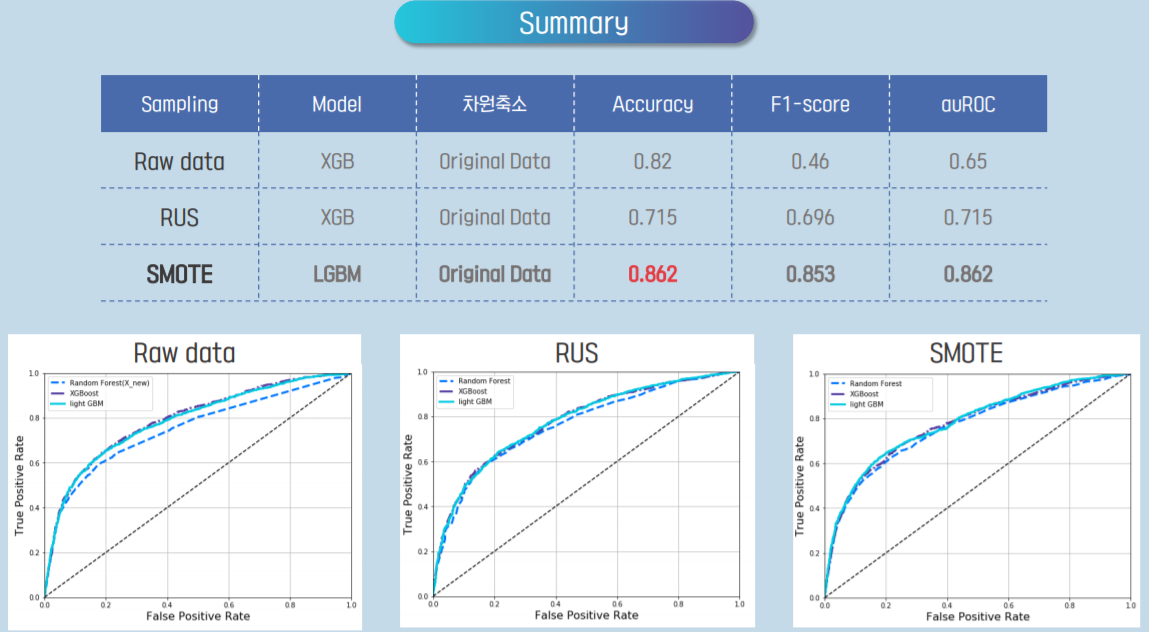


# Interpret of result


### In the prediction of model classification,
### SMOTE – LGBM applied to the basic data has the best performance.

### In the case of RUS, the effect of information loss on data was greater than solving the imbalance problem.

### All scores are lost unless taking proper dimension of reduction